# Food classification and nutrition values estimation



Bu Notebookta InceptionV3 modeli ile gıda tespiti ve besin değerleri çıkarımı gerçekleştirilmiştir.

### **Download and extract Food 101 Dataset**

In [1]:
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import cv2
import csv
import pandas as pd

In [2]:
#Function to download data and extract
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [3]:
# Download data and extract it to folder

get_data_extract()

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

### **Understand dataset structure and files**

In [4]:
# Check the extracted dataset folder
!ls food-101/

images	license_agreement.txt  meta  README.txt


**images** folder contains 101 folders with 1000 images    
Each folder contains images of a specific food class

In [5]:
os.listdir('food-101/images')

['oysters',
 'takoyaki',
 'beef_carpaccio',
 'spring_rolls',
 'garlic_bread',
 'churros',
 'pad_thai',
 'pork_chop',
 'chocolate_mousse',
 'club_sandwich',
 'baklava',
 'creme_brulee',
 'cheese_plate',
 'hummus',
 'pizza',
 'beet_salad',
 'chicken_curry',
 'crab_cakes',
 'apple_pie',
 'french_toast',
 'scallops',
 'macaroni_and_cheese',
 'ceviche',
 'cheesecake',
 'frozen_yogurt',
 'poutine',
 'pancakes',
 'falafel',
 'steak',
 'hot_dog',
 'fried_rice',
 'donuts',
 'bibimbap',
 'macarons',
 'prime_rib',
 'risotto',
 'lobster_bisque',
 'foie_gras',
 'bruschetta',
 'paella',
 'chocolate_cake',
 'eggs_benedict',
 'huevos_rancheros',
 'beef_tartare',
 'cannoli',
 'lobster_roll_sandwich',
 'croque_madame',
 'dumplings',
 'samosa',
 'filet_mignon',
 'hot_and_sour_soup',
 'waffles',
 'french_fries',
 'onion_rings',
 'cup_cakes',
 'fried_calamari',
 'peking_duck',
 'tacos',
 'shrimp_and_grits',
 'panna_cotta',
 'escargots',
 'omelette',
 'pho',
 'spaghetti_bolognese',
 'mussels',
 'hamburger',

**meta** folder contains the text files - train.txt and test.txt  
**train.txt** contains the list of images that belong to training set  
**test.txt** contains the list of images that belong to test set  
**classes.txt** contains the list of all classes of food

In [6]:
os.listdir('food-101/meta')

['labels.txt',
 'test.json',
 'test.txt',
 'classes.txt',
 'train.json',
 'train.txt']

In [7]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [8]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito



### **Visualize random image from each of the 101 classes**

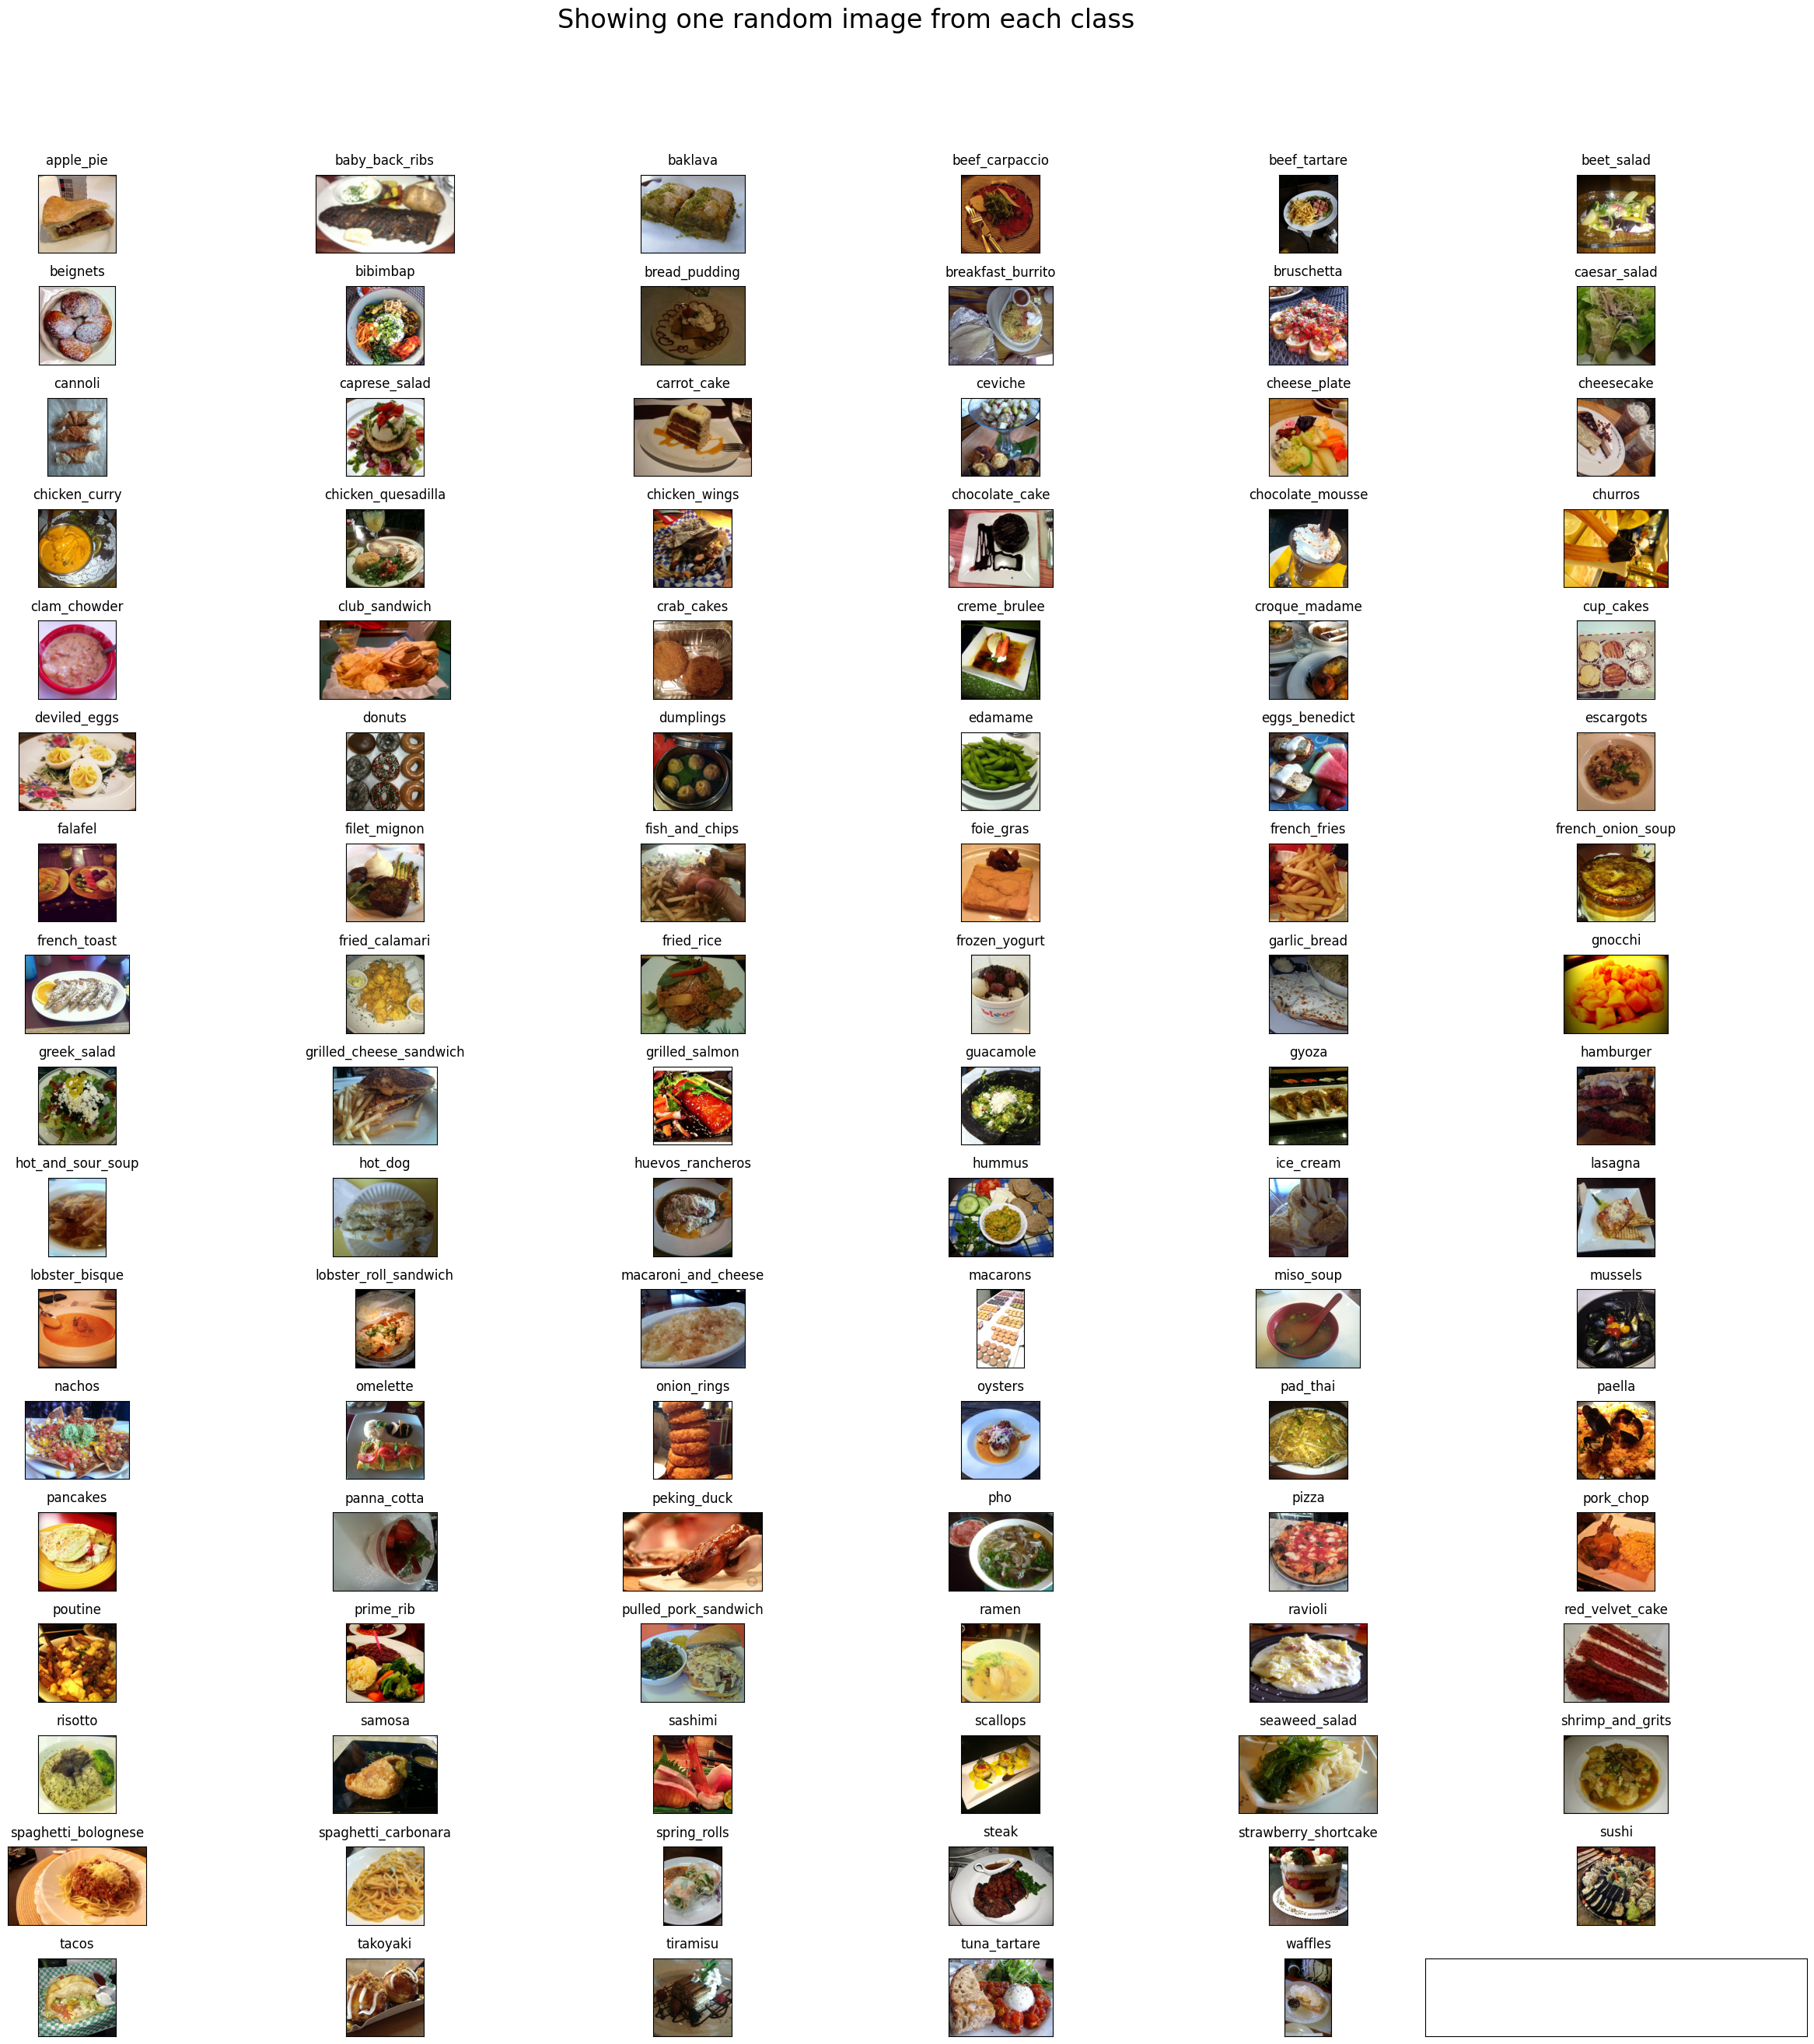

In [9]:
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

### **Split the image data into train and test using train.txt and test.txt**

In [10]:
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [11]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
%cd /
print("Creating train data...")
prepare_data('content/food-101/meta/train.txt', 'content/food-101/images', 'train')

/
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying 

In [12]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('content/food-101/meta/test.txt', 'content/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [13]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [14]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


### **Create a subset of data with 6 classes - train_mini and test_mini for experimenting**

In [15]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [16]:
foods_sorted

['baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster_roll_sandwich

In [17]:
#Function to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))
      

In [18]:
# picking 6 food items and generating separate data folders for the same
food_list = ['apple_pie','pizza','omelette','hamburger','steak','sushi']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [19]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette
Copying images into hamburger
Copying images into steak
Copying images into sushi


In [20]:
print("Total number of samples in train folder")

!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
4500


In [21]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette
Copying images into hamburger
Copying images into steak
Copying images into sushi


In [22]:
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
1500


### **Fine tune Inception Pre-trained model using Food 101 dataset**

In [23]:
K.clear_session()
n_classes = 6
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 4500 
nb_validation_samples = 1500 
image_size = (299, 299)
batch_size = 16


model_class = InceptionV3

# Clear previous session and set random seed
np.random.seed(42)
tf.random.set_seed(42)



In [24]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)



In [25]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Load the training and validation data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)



Found 4500 images belonging to 6 classes.
Found 1500 images belonging to 6 classes.


In [26]:
# Load the pre-trained model without top layers
base_model = model_class(
    weights='imagenet',
    include_top=False,
    input_tensor=tf.keras.Input(shape=(299, 299, 3))
)

  # Add custom top layers for food detection
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)



87910968/87910968 [==============================] - 5s 0us/step


In [27]:
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers during initial training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Training {model_class.__name__} model...")

checkpointer = ModelCheckpoint(filepath=f'best_{model_class.__name__}_6class.hdf5',
                                verbose=1, save_best_only=True)
csv_logger = CSVLogger(f'history_{model_class.__name__}_6class.log')

# Train the model
model.fit(train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    epochs=15,
    verbose=1)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(validation_generator, steps=nb_validation_samples // batch_size)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



Training InceptionV3 model...
Epoch 1/15
281/281 [==============================] - 120s 379ms/step - loss: 0.7127 - accuracy: 0.7536 - val_loss: 0.4417 - val_accuracy: 0.8461
Epoch 2/15
281/281 [==============================] - 105s 372ms/step - loss: 0.5508 - accuracy: 0.8055 - val_loss: 0.3492 - val_accuracy: 0.8824
Epoch 3/15
281/281 [==============================] - 104s 370ms/step - loss: 0.4962 - accuracy: 0.8218 - val_loss: 0.3511 - val_accuracy: 0.8844
Epoch 4/15
281/281 [==============================] - 104s 371ms/step - loss: 0.4670 - accuracy: 0.8370 - val_loss: 0.3461 - val_accuracy: 0.8851
Epoch 5/15
281/281 [==============================] - 104s 370ms/step - loss: 0.4571 - accuracy: 0.8419 - val_loss: 0.3178 - val_accuracy: 0.8858
Epoch 6/15
281/281 [==============================] - 104s 368ms/step - loss: 0.4160 - accuracy: 0.8533 - val_loss: 0.3134 - val_accuracy: 0.8938
Epoch 7/15
281/281 [==============================] - 104s 370ms/step - loss: 0.4100 - accurac

In [28]:
# Unfreeze some layers for fine-tuning
for layer in model.layers[175:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=f'best_{model_class.__name__}_6class.hdf5',
                                verbose=1, save_best_only=True)
csv_logger = CSVLogger(f'history_{model_class.__name__}_6class.log')

# Fine-tune the model
history = model.fit(
      train_generator,
      steps_per_epoch=nb_train_samples // batch_size,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples // batch_size,
      epochs=15,
      verbose=1,
      callbacks=[csv_logger, checkpointer])

model.save(f'model_trained_{model_class.__name__}.hdf5')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(validation_generator, steps=nb_validation_samples // batch_size)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/15
281/281 [==============================] - ETA: 0s - loss: 0.8093 - accuracy: 0.7268
Epoch 1: val_loss improved from inf to 0.75520, saving model to best_InceptionV3_6class.hdf5
281/281 [==============================] - 128s 379ms/step - loss: 0.8093 - accuracy: 0.7268 - val_loss: 0.7552 - val_accuracy: 0.8145
Epoch 2/15
281/281 [==============================] - ETA: 0s - loss: 0.5462 - accuracy: 0.8171
Epoch 2: val_loss improved from 0.75520 to 0.54133, saving model to best_InceptionV3_6class.hdf5
281/281 [==============================] - 105s 372ms/step - loss: 0.5462 - accuracy: 0.8171 - val_loss: 0.5413 - val_accuracy: 0.8353
Epoch 3/15
281/281 [==============================] - ETA: 0s - loss: 0.4273 - accuracy: 0.8557
Epoch 3: val_loss improved from 0.54133 to 0.37710, saving model to best_InceptionV3_6class.hdf5
281/281 [==============================] - 105s 372ms/step - loss: 0.4273 - accuracy: 0.8557 - val_loss: 0.3771 - val_accuracy: 0.8911
Epoch 4/15
281/281 [

In [29]:
class_map_6 = train_generator.class_indices
class_map_6

{'apple_pie': 0,
 'hamburger': 1,
 'omelette': 2,
 'pizza': 3,
 'steak': 4,
 'sushi': 5}

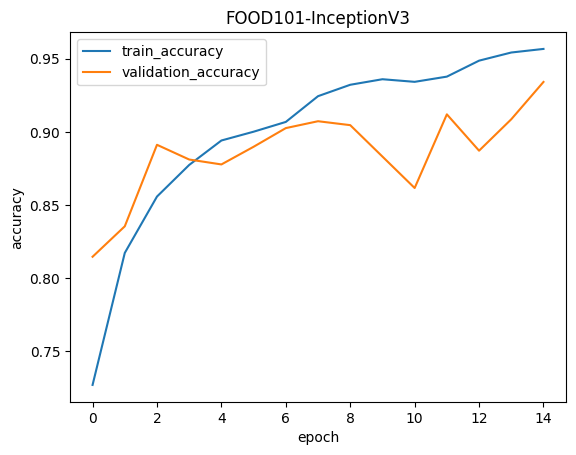

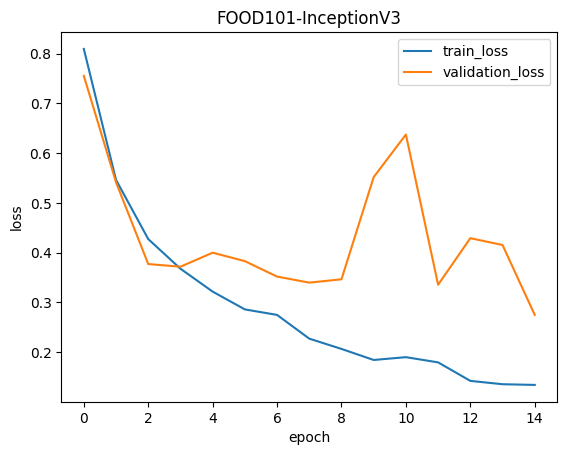

In [30]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()



plot_accuracy(history,f'FOOD101-{model_class.__name__}')
plot_loss(history,f'FOOD101-{model_class.__name__}')

* **Grafikler, modelin doğruluğunun epochlarla beraber arttığını ve kaybın azaldığını göstermektedir.** 

 


**Import and read selected food classes of nutrition values** 

In [32]:
data = pd.read_csv(r'content/calories_data.csv')   
df = pd.DataFrame(data,  columns=['food_item', 'portion', 'calories', 'carbohydrate', 'protein', 'fat'])


### **Predicting classes for new images from internet using the best trained model**

In [33]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best_InceptionV3 = load_model('best_InceptionV3_6class.hdf5',compile = False)


CPU times: user 2.53 s, sys: 116 ms, total: 2.65 s
Wall time: 2.6 s


In [34]:
# Downloading images from internet using the URLs
!wget -O apple_pie.jpg https://assets.epicurious.com/photos/59bc150e74febd49ca741558/1:1/w_3197,h_3197,c_limit/CINNAMON-CRUMBLE-APPLE-PIE-RECIPE-07092017.jpg
!wget -O omelette.jpg https://static.onecms.io/wp-content/uploads/sites/23/2018/05/10/golden_omelet.jpg
!wget -O pizza.jpg https://cdn.create.vista.com/api/media/small/32627411/stock-photo-pizza
!wget -O hamburger.jpg https://www.pelinchef.com/wp-content/uploads/2014/05/ev-yap%C4%B1m%C4%B1-hamburger.jpg
!wget -O steak.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT79YhHeRN_65N1RQ5PWvQ13MD4VpFx-Jn2QQ&usqp=CAU
!wget -O sushi.jpg https://www.kikkoman.com.tr/fileadmin/_processed_/6/1/csm_kikkoman-rezepte-content-vegetarian-maki-sushi_-1080x720_f57309b188.jpg

--2023-06-07 19:12:59--  https://assets.epicurious.com/photos/59bc150e74febd49ca741558/1:1/w_3197,h_3197,c_limit/CINNAMON-CRUMBLE-APPLE-PIE-RECIPE-07092017.jpg
Resolving assets.epicurious.com (assets.epicurious.com)... 151.101.0.239, 151.101.64.239, 151.101.128.239, ...
Connecting to assets.epicurious.com (assets.epicurious.com)|151.101.0.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2167603 (2.1M) [image/jpeg]
Saving to: ‘apple_pie.jpg’

apple_pie.jpg       100%[===================>]   2.07M  --.-KB/s    in 0.006s  

2023-06-07 19:12:59 (322 MB/s) - ‘apple_pie.jpg’ saved [2167603/2167603]

--2023-06-07 19:12:59--  https://static.onecms.io/wp-content/uploads/sites/23/2018/05/10/golden_omelet.jpg
Resolving static.onecms.io (static.onecms.io)... 151.101.2.137, 151.101.66.137, 151.101.130.137, ...
Connecting to static.onecms.io (static.onecms.io)|151.101.2.137|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https:/

In [41]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred[0])
    food_list.sort()
    pred_value = food_list[index]
    print(pred_value)
    print(df.loc[index])

    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()


1/1 [==============================] - 0s 27ms/step
apple_pie
food_item          apple_pie
portion         medium slice
calories                 442
carbohydrate         40.35gr
protein                4.3gr
fat                  28.78gr
Name: 0, dtype: object


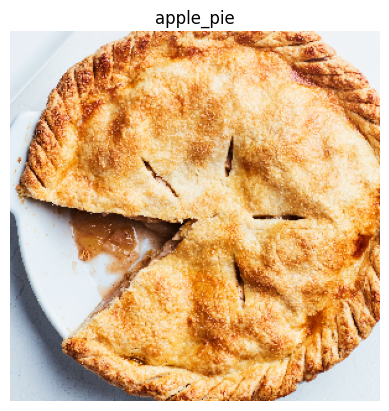

1/1 [==============================] - 0s 26ms/step
omelette
food_item       omelette
portion            100gr
calories             101
carbohydrate      1.27gr
protein           6.69gr
fat               7.94gr
Name: 2, dtype: object


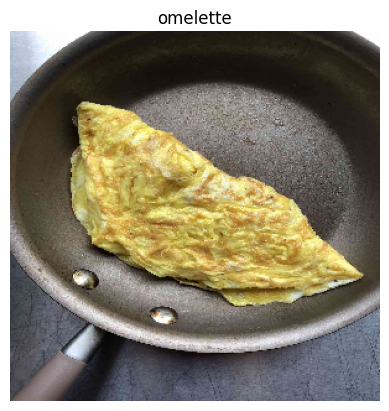

1/1 [==============================] - 0s 27ms/step
pizza
food_item              pizza
portion         medium slice
calories                 243
carbohydrate         39.66gr
protein               7.59gr
fat                   3.63gr
Name: 3, dtype: object


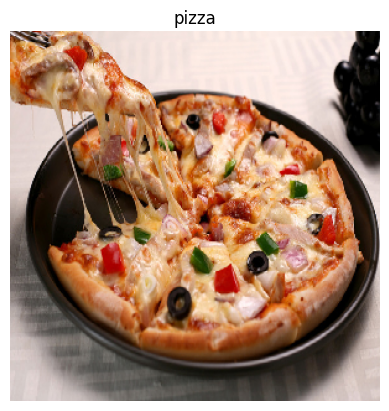

1/1 [==============================] - 0s 29ms/step
hamburger
food_item       hamburger
portion             190gr
calories              313
carbohydrate      37.78gr
protein           13.34gr
fat               11.62gr
Name: 1, dtype: object


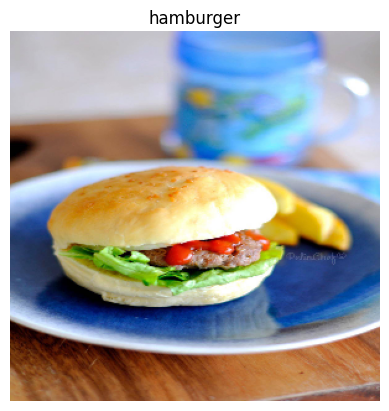

1/1 [==============================] - 0s 26ms/step
steak
food_item        steak
portion          250gr
calories           570
carbohydrate       0gr
protein           60gr
fat             34.9gr
Name: 4, dtype: object


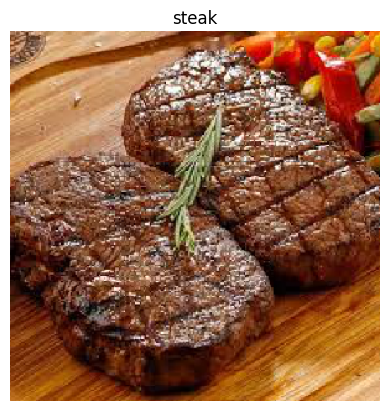

1/1 [==============================] - 0s 30ms/step
sushi
food_item         sushi
portion         1 piece
calories             46
carbohydrate     6.65gr
protein          1.75gr
fat               1.4gr
Name: 5, dtype: object


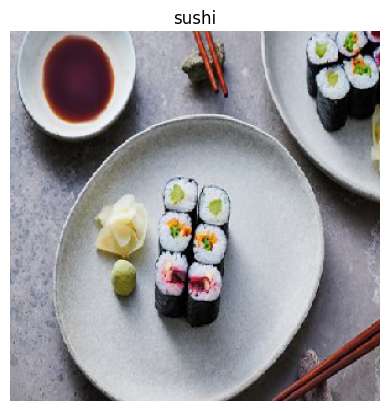

In [42]:
# Make a list of downloaded images and test the trained InceptionV3 model
images = []
images.append('apple_pie.jpg')
images.append('omelette.jpg')
images.append('pizza.jpg')
images.append('hamburger.jpg')
images.append('steak.jpg')
images.append('sushi.jpg')


predict_class(model_best_InceptionV3, images, True)
